# Straylight as a function of wavelength and temperature
We apply the straylight correction (v2) to the MRS FM MTS extended source observations covering all spectral bands. We then examine how the straylight changes as a function of wavelength. This test is performed for three different blackbody temperatures, namely 400K, 600K, and 800K. Given that the straylight correction step comes before the fringe calibration step and the flux calibration step, the related corrections are not applied to the LVL2 data.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]

In [3]:
# Define paths to data
workDir       = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir        = workDir+'cdp_data/'
d2cMapDir     = workDir+'distortionMaps/'
MTSDir        = workDir+'MRSFluxCal/MIRI_CDP6MRSFluxCal/MtsIrradiance/'
lvl2path      = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

sliceMap  = {}
sizeMap   = {}
validMap  = {}
lambdaMap = {}

for band in bands:
    #print "Band {}".format(band)
    d2cMaps         = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band=band,d2cMaps=d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1

In [ ]:
# Populate dictionaries with maps of S_pix [DN/sec]
# S_pix is the average slope of the BB measurement with the average slope of the
# background measurement subtracted.

S_pixMap = funcs.load_obj('S_pixMap',path='')
S_pixMap_STRCORR = funcs.load_obj('S_pixMap_STRCORR',path='')

# # -- Uncomment to re-run
# S_pixMap = {}
# S_pixMap_STRCORR = {} # straylight-corrected signal
# for BBTemp in ["400K","600K", "800K"]:
#     print "BBTemp {}".format(BBTemp)
#     S_pixMap[BBTemp] = {}
#     S_pixMap_STRCORR[BBTemp] = {}
#     for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
#         print "Band {}".format(band)
#         S_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
#         S_pixMap_STRCORR[BBTemp][band] = np.full( validMap[band].shape, np.nan )
#         hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,output='filename')[0])
#         slopeHOLE = hdulist[0].data[0,:,:]
#         slopeHOLE_STRCORR = funcs.straylightCorrection(slopeHOLE,sliceMap=sliceMap[band])
#         maskHOLE = hdulist[0].data[2,:,:]
#         hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,output='filename')[1])
#         slopeBLANK = hdulist[0].data[0,:,:]
#         slopeBLANK_STRCORR = funcs.straylightCorrection(slopeBLANK,sliceMap=sliceMap[band])
#         maskBLANK = hdulist[0].data[2,:,:]
#         sel = (validMap[band]==1) & (maskHOLE==0) & (maskBLANK==0)
#         S_pixMap[BBTemp][band][sel] = slopeHOLE[sel] - slopeBLANK[sel]
#         S_pixMap_STRCORR[BBTemp][band][sel] = slopeHOLE_STRCORR[sel] - slopeBLANK_STRCORR[sel]

# # save outputs
# funcs.save_obj(S_pixMap,'S_pixMap',path='')
# funcs.save_obj(S_pixMap_STRCORR,'S_pixMap_STRCORR',path='')

<IPython.core.display.Javascript object>


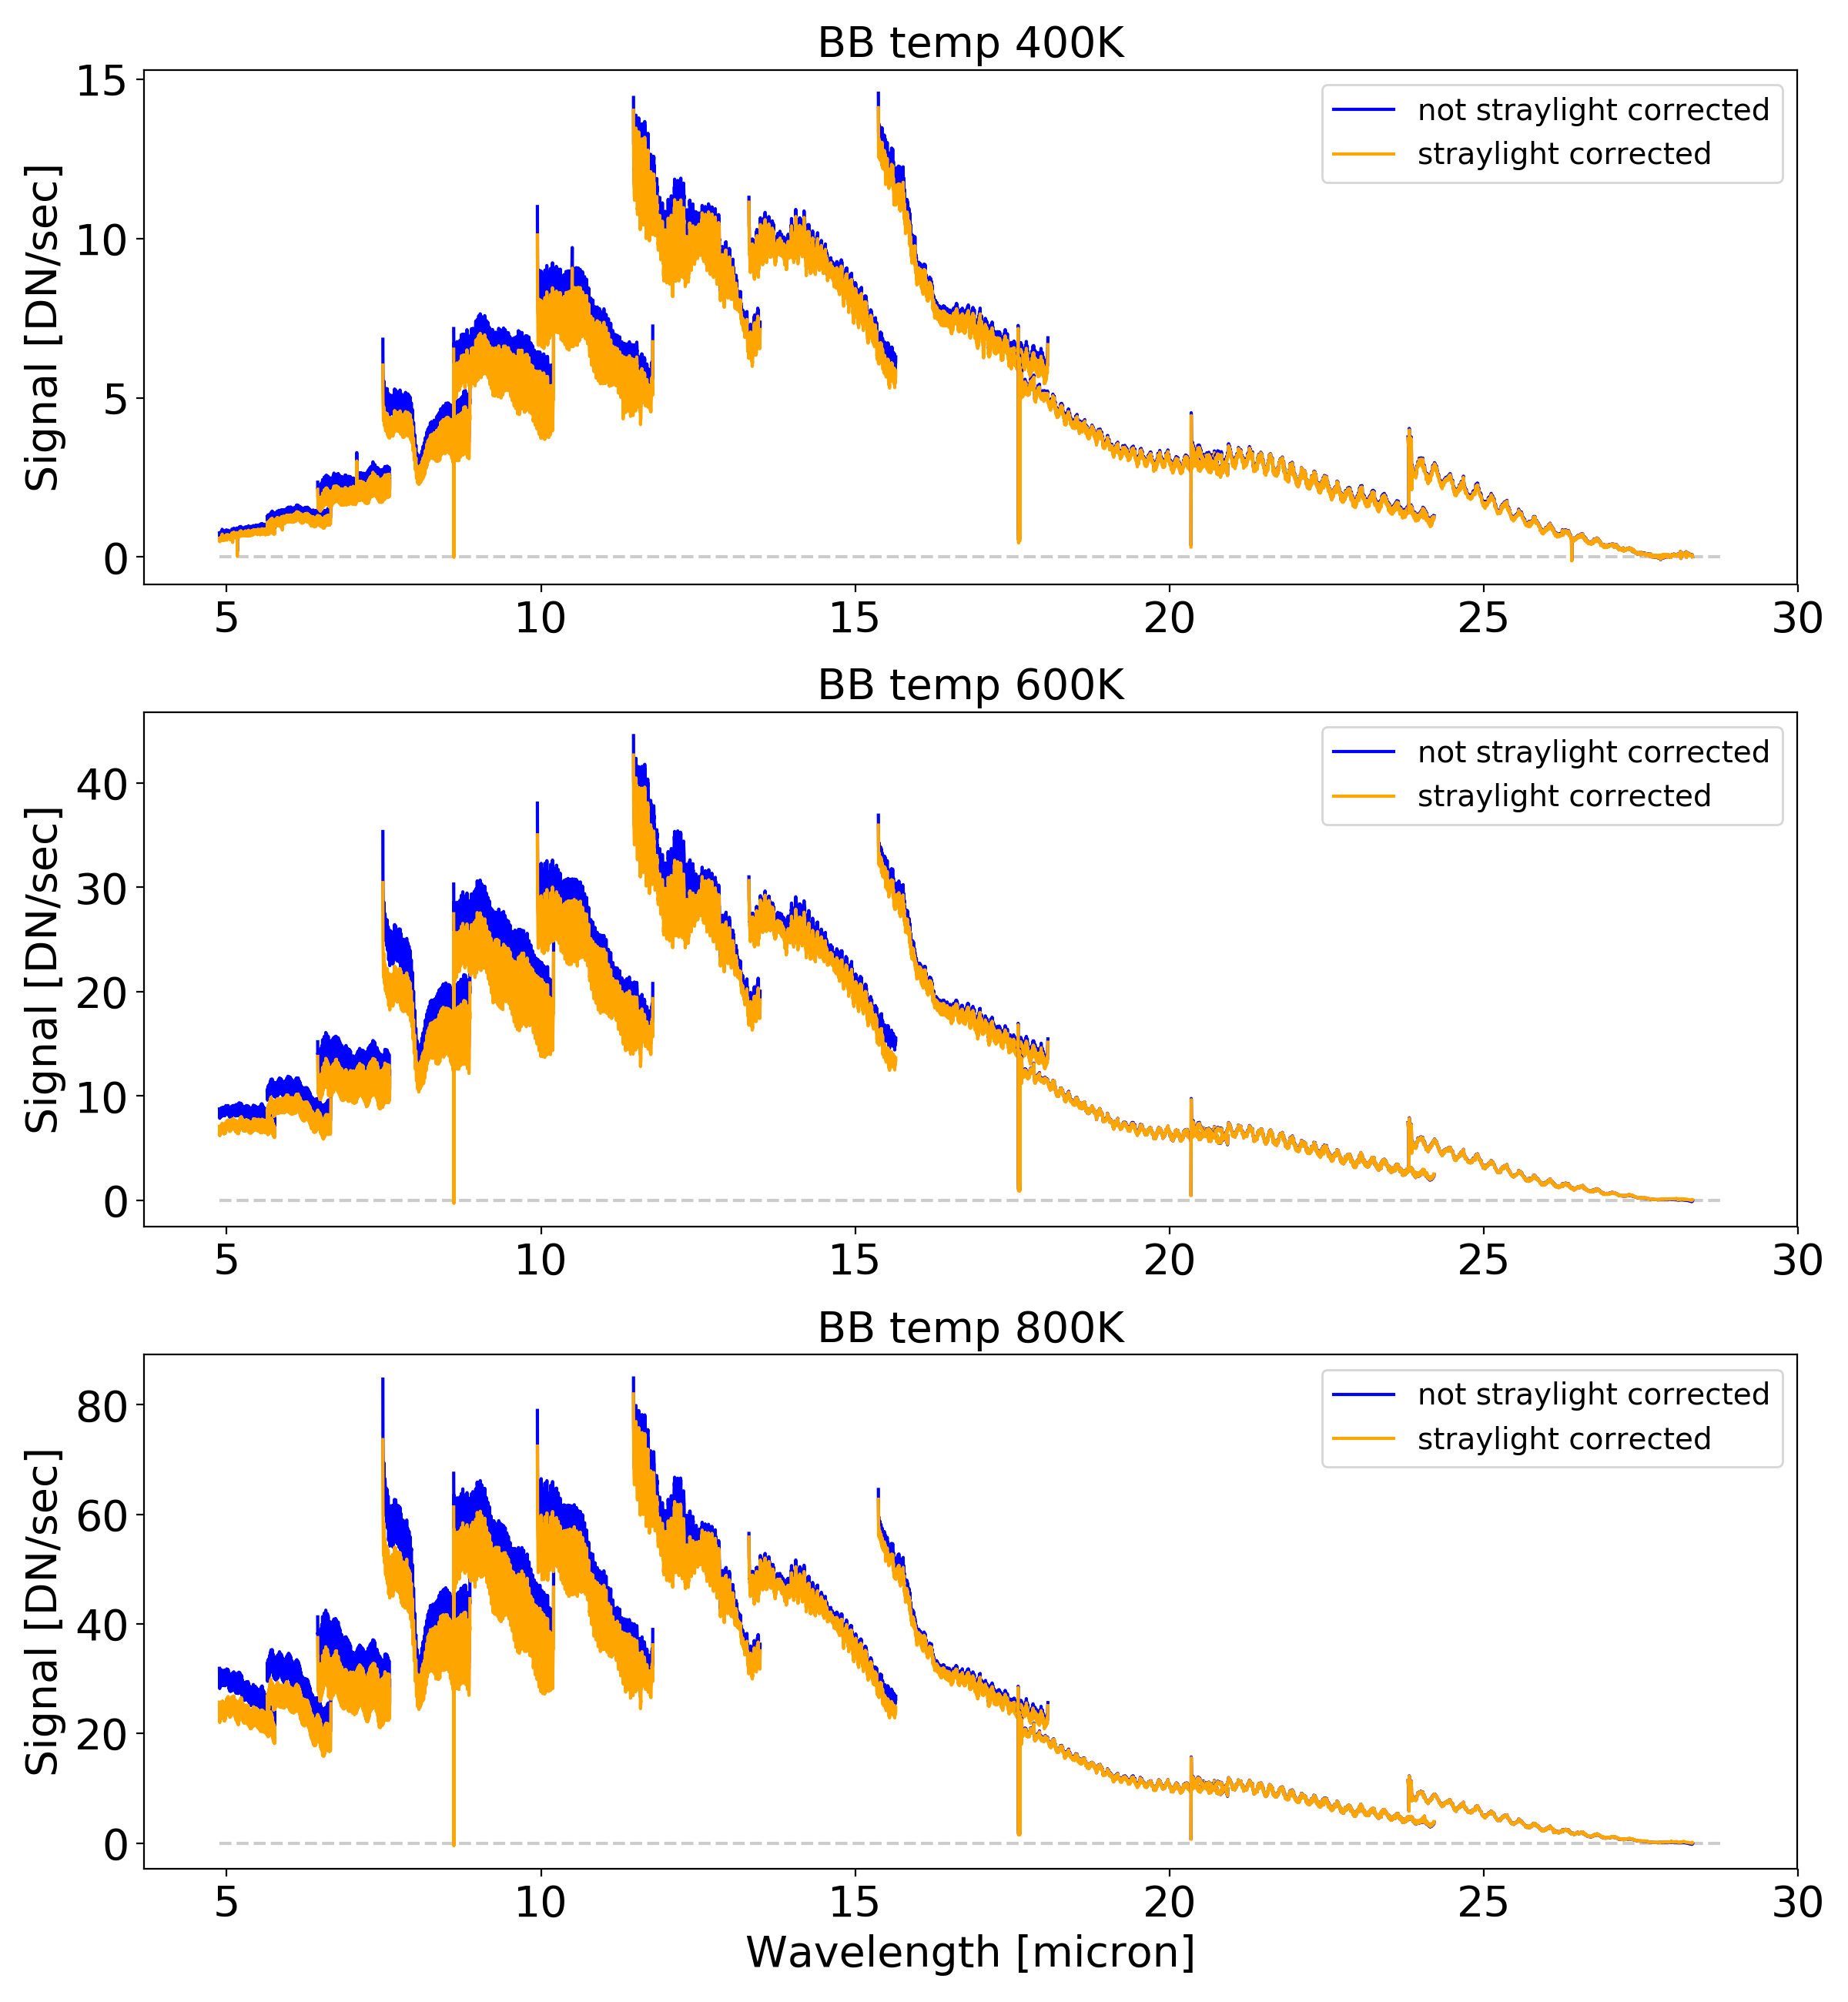

In [5]:
fig,axs = plt.subplots(3,1,figsize=(12,13))
plot = -1
for BBTemp in ["400K","600K", "800K"]:
    plot +=1
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
        ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
        axs[plot].plot(lambdaMap[band][ypos,xpos],S_pixMap[BBTemp][band][ypos,xpos],'b')
        axs[plot].plot(lambdaMap[band][ypos,xpos],S_pixMap_STRCORR[BBTemp][band][ypos,xpos],'orange')
    axs[plot].hlines(0,4.88,28.8,'gray',alpha=0.4,linestyle='dashed')
    legend_elements = [Line2D([0],[0],color='b',label='not straylight corrected'),Line2D([0],[0],color='orange',label='straylight corrected')]
    axs[plot].legend(handles=legend_elements)
    axs[plot].set_title("BB temp {}".format(BBTemp))
    axs[plot].set_ylabel('Signal [DN/sec]')
axs[2].set_xlabel('Wavelength [micron]')
plt.tight_layout()

## Remarks:
* The effect of the straylight correction step diminishes from the lowest to the highest wavelengths.  
  
How does the amount of straylight vary with temperature? Let's plot the ratio of the above spectra. We plot the signal with straylight (i.e. the "not straylight corrected" spectrum) divided by the "straylight corrected" spectrum (in other words we divide the blue curve by the orange curve). Mathematically:
$$  
\frac{corrected\_signal + straylight}{corrected\_signal} = 1 + \frac{straylight}{corrected\_signal}  
$$  

<IPython.core.display.Javascript object>


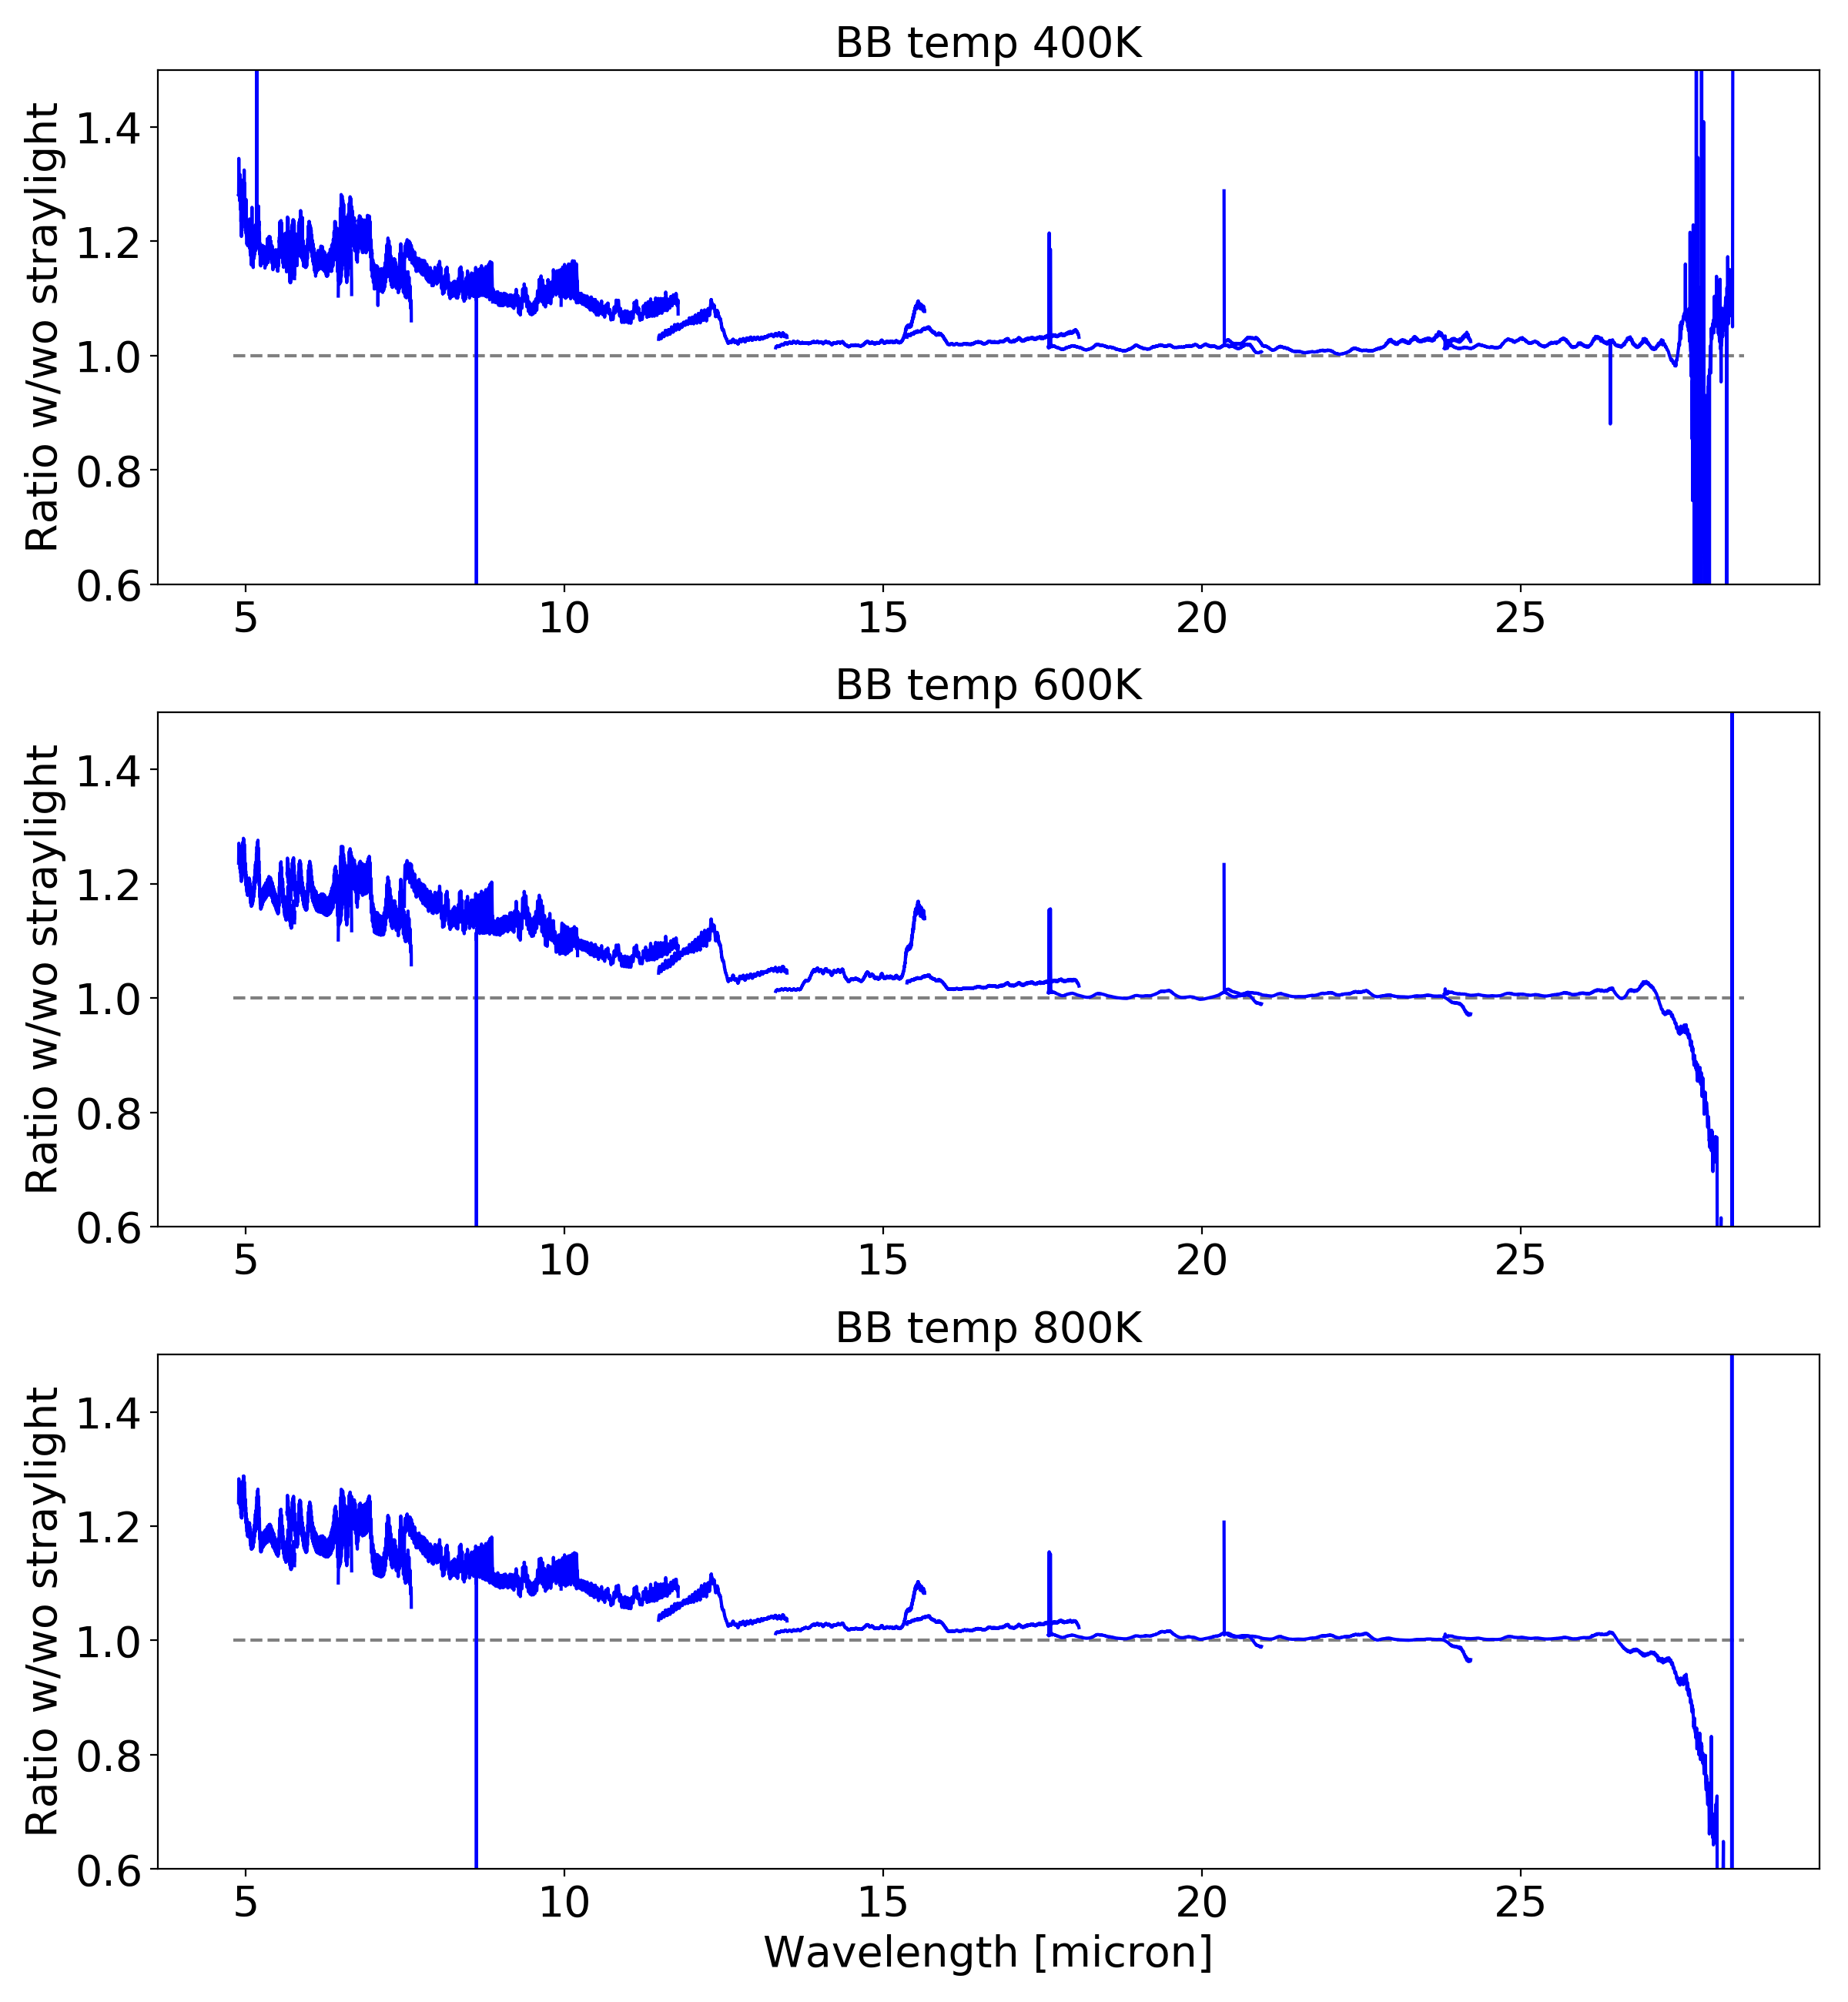

<IPython.core.display.Javascript object>


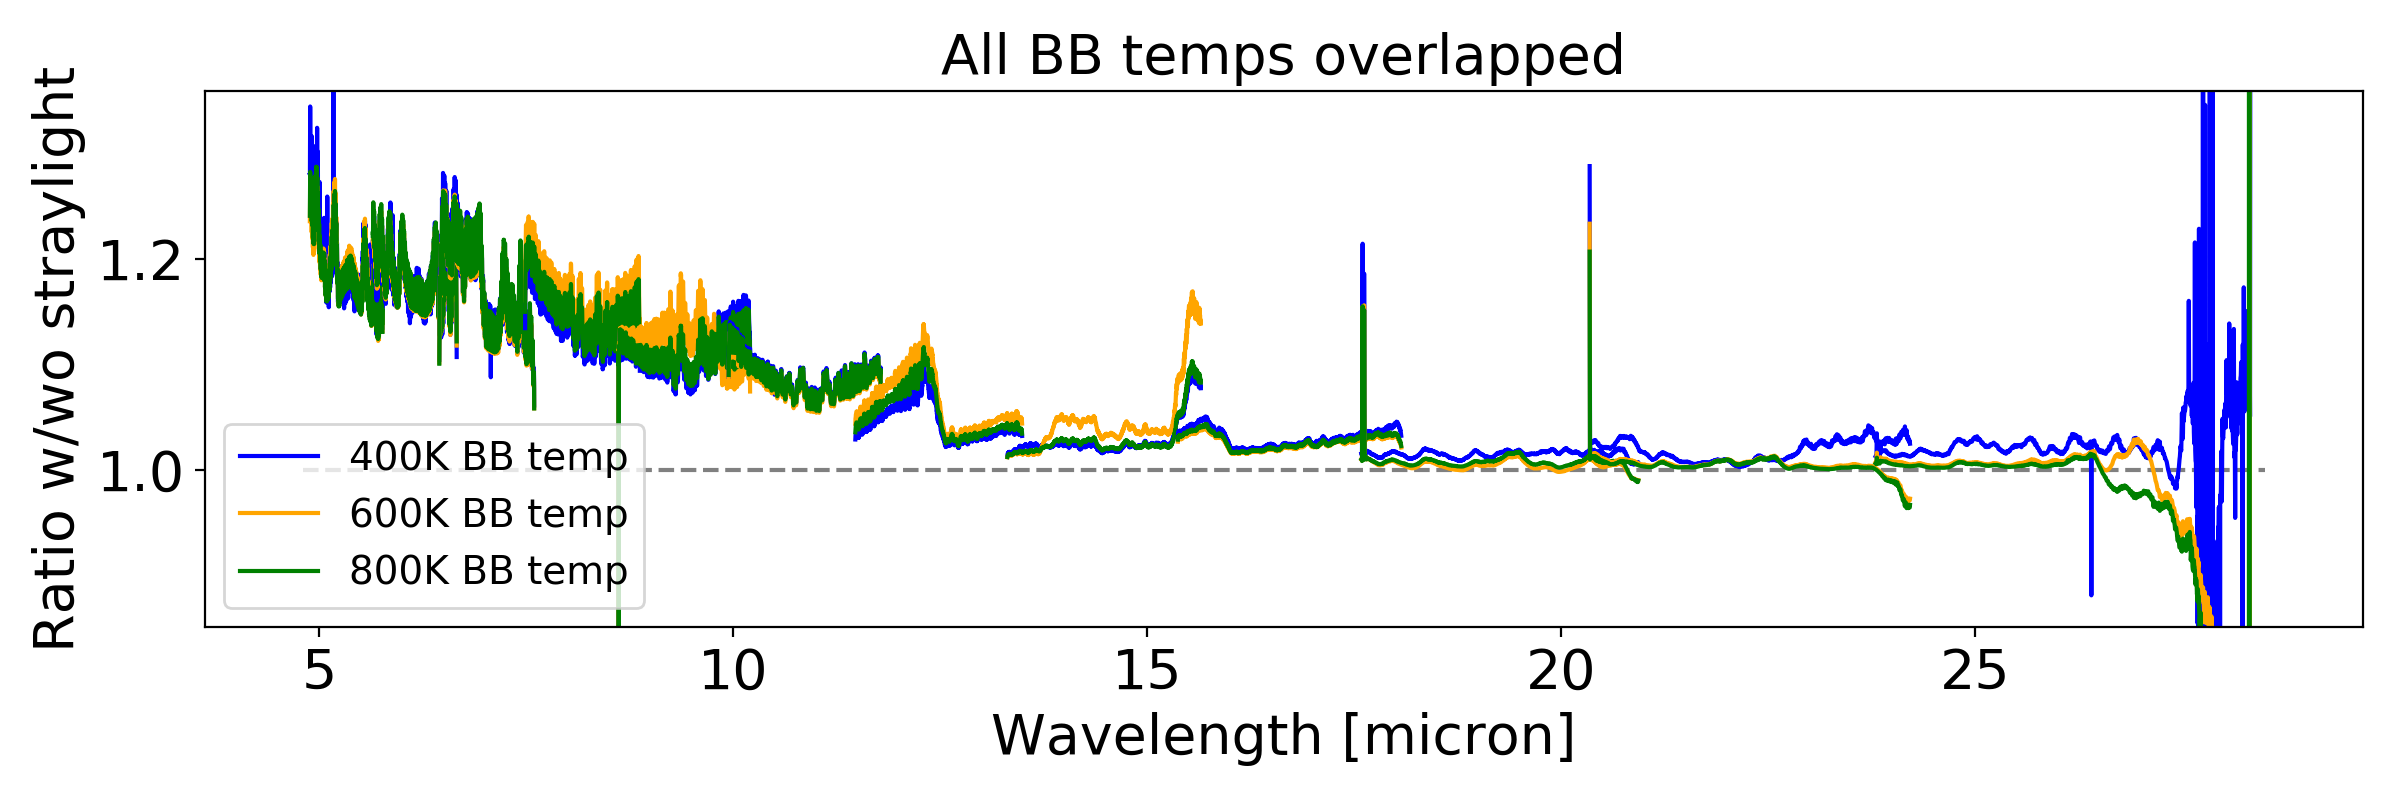

In [6]:
fig,axs = plt.subplots(3,1,figsize=(12,13))
plot = -1
for BBTemp in ["400K","600K", "800K"]:
    plot +=1
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
        ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
        axs[plot].plot(lambdaMap[band][ypos,xpos],S_pixMap[BBTemp][band][ypos,xpos]/S_pixMap_STRCORR[BBTemp][band][ypos,xpos],'b')
    axs[plot].hlines(1,4.8,28.5,'gray',linestyle='dashed')
    axs[plot].set_ylim(0.6,1.5)
    axs[plot].set_title("BB temp {}".format(BBTemp))
    axs[plot].set_ylabel('Ratio w/wo straylight')
axs[2].set_xlabel('Wavelength [micron]')
plt.tight_layout()

plt.figure(figsize=(12,4))
for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap['400K'][band][ypos,xpos]/S_pixMap_STRCORR['400K'][band][ypos,xpos],'b')
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap['600K'][band][ypos,xpos]/S_pixMap_STRCORR['600K'][band][ypos,xpos],'orange')
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap['800K'][band][ypos,xpos]/S_pixMap_STRCORR['800K'][band][ypos,xpos],'g')
plt.hlines(1,4.8,28.5,'gray',linestyle='dashed')
legend_elements = [Line2D([0],[0],color='b',label='400K BB temp'),Line2D([0],[0],color='orange',label='600K BB temp'),Line2D([0],[0],color='g',label='800K BB temp')]
plt.legend(handles=legend_elements)
plt.ylim(0.85,1.36)
plt.title('All BB temps overlapped')
plt.xlabel('Wavelength [micron]')
plt.ylabel(r'Ratio w/wo straylight')
plt.tight_layout()

## Remarks:
* The amount of straylight seems to decrease monotonically with wavelength. Is this expected? Shouldn't the amount of straylight be correlated to the absolute signal level rather than wavelength?
* The ratio of the MRS spectrum with and without straylight (straylight-subtracted) is similar for the three BB temperatures, despite the (very?) different absolute signal levels. Admittedly one would, perhaps, be inclined to say that the ratio follows the contribution of an undefined blackbody curve. Whatever the case may be, it appears that the straylight acts more like a signal gain rather than a source-temperature-dependent quantity.
* The behavior of the ratio within one MRS spectral band seems to be erratic. This behavior has already been examined, and determined to be related to the definition of the detector2cube slice map (see Notebook 1).
* The spectral behavior in band 4C is currently not justifiable, other than saying that the calibration effort at these furthest bands is still ongoing. *That said* it is curious.. that the signal deviates so "cleanly" starting from the middle of band 4C. Of course at the long wavelengths there's always a question of what the contribution of the thermal background is (of the test setup). Perhaps examining the MIRI internal calibration source data (CCC closed) may shed some light on this (see Notebook 3).
* The ratio of the MRS spectrum with and without straylight yields a high-frequency fringe residual up to and including band 3A (13.5um). This implies that the straylight correction changes the phase/amplitude of the intrinsic spectrum high-frequency fringe ever so slightly. This has important ramifications for the derivation of an MRS fringe correction.
* Something peculiar is happening at 12.3um and at 15.5um (steep drop and steep rise in ratio respectively).
* The signal of the 400K BB spectrum appears to "pick up" between 22.5um and 26um. This is not the case for the 600K BB or the 800K BB spectrum. 

# Conclusions
* The straylight signal determined for different blackbody source temperatures appears to vary with wavelength rather than with absolute intensity (straylight not correlated to LVL2 MRS data blackbody spectrum for any given temperature).
* The ratio of straylight signal w.r.t. the scientific signal is the same for all three blackbody temperatures, despite the different absolute signal levels between the respective MRS bands.
* The ratio of the MRS spectrum with and without straylight yields a high-frequency fringe residual up to and including band 3A (13.5um). This implies that the straylight correction changes the phase/amplitude of the intrinsic spectrum high-frequency fringe ever so slightly (important in the context of deriving an accurate fringe correction).

# Follow-up question:
* How does the derived response affect the internal calibration source spectrum?